# Notebook_eda

voir le README pour le résumé du projet

Colonnes : 

- InvoiceNo : Il s'agit du numéro d'identification de la facture. Chaque transaction est généralement associée à un numéro de facture unique. Ce numéro peut être utilisé pour regrouper les articles achetés dans une même transaction.

- StockCode : C'est le code d'identification du produit ou de l'article. Chaque produit ou article disponible à la vente a généralement un code unique qui l'identifie. Ce code peut être utilisé pour associer un article spécifique à une transaction.

- Description : Cette colonne contient la description du produit ou de l'article correspondant au code StockCode. Il s'agit d'une description textuelle qui fournit des informations sur le produit ou l'article, telles que sa marque, son nom ou ses caractéristiques.

- Quantity : C'est le nombre d'unités de chaque produit ou article acheté dans une transaction donnée. Il indique combien d'unités d'un produit spécifique ont été achetées lors de cette transaction.

- InvoiceDate : Il s'agit de la date et de l'heure auxquelles la transaction a été effectuée. Cette information peut être utile pour l'analyse temporelle, la segmentation des données ou la détection de tendances saisonnières.

- UnitPrice : C'est le prix unitaire d'un produit ou article. Il représente le coût d'une seule unité du produit. Le prix total d'un produit dans une transaction peut être calculé en multipliant la quantité par le prix unitaire.

- CustomerID : Il s'agit de l'identifiant du client associé à la transaction. Chaque client a un identifiant unique qui peut être utilisé pour regrouper les transactions par client ou pour suivre les comportements d'achat spécifiques à chaque client.

- Country : Cette colonne indique le pays où la transaction a eu lieu ou le pays associé au client. Elle peut être utilisée pour analyser les ventes par pays ou pour segmenter les données en fonction des régions géographiques.

In [2]:
# import des librairies
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

# models 
import pyfpgrowth
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [3]:
# import des données 
df = pd.read_csv("data/data.csv", encoding= 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Fonctions

In [4]:
def unique(df, liste):
    for i in liste:
        result = df[i].unique()
        print(f"******************************{i}******************************")
        print(result)

In [5]:
def remove_outliers_df(df, cols=None, threshold=1.5):
    """
    Traite les outliers dans un DataFrame en utilisant la méthode de l'écart interquartile (IQR) pour chaque colonne.
    
    Arguments:
    - df : DataFrame, le DataFrame contenant les données à traiter.
    - cols : liste, les noms des colonnes à traiter (par défaut : None pour toutes les colonnes).
    - threshold : float, la valeur seuil pour détecter les outliers (par défaut : 1.5).
    
    Returns:
    - DataFrame, le DataFrame avec les outliers supprimés.
    """
    if cols is None:
        cols = df.columns
    
    filtered_data = df.copy()
    
    for col in cols:
        # Calcul de Q1 (premier quartile) et Q3 (troisième quartile) pour la colonne
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        
        # Calcul de l'écart interquartile (IQR) pour la colonne
        iqr = q3 - q1
        
        # Calcul des limites supérieure et inférieure pour détecter les outliers pour la colonne
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        
        # Filtrage des valeurs en dehors des limites pour la colonne
        filtered_data = filtered_data[(filtered_data[col] >= lower_bound) & (filtered_data[col] <= upper_bound)]
    
    return filtered_data

In [6]:
def transform_str_to_int(column):
    unique_values = list(set(column))
    mapping = {value: i+1 for i, value in enumerate(unique_values)}
    return [mapping.get(value, 0) for value in column]

## EDA

In [7]:
# nombre de lignes et de colonnes du df
df.shape

(541909, 8)

In [8]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
# le type de données pour chaque colonne
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [12]:
# nombre de duplicates
df.duplicated().sum()

5268

In [13]:
# drop les duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [14]:
# nombre de NaN pour chaque colonne
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

### NaN

L'objectif ici est d'observer les NaN plus en détail pour essayer de voir si ces valeurs sont manquantes pour une raison particulière 

In [15]:
# liste de toutes les colonnes
colonnes = ['Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

In [16]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [17]:
description_nan = df.loc[df["Description"].isnull()]
description_nan.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [18]:
unique(description_nan, colonnes)

******************************Description******************************
[nan]
******************************Quantity******************************
[   56     1     3    23   -10   -38    19    57   -20    -6   110   -22
    70    -2   -30   -70  -130   -80  -120   -40    -5   -12   -25   -14
   -15   -69    -3  -140  -320     5   -24   -21   120     7    10    13
   -19   -11   -18   -44   -50    -9   -77     2  -223   144    34     8
    30    -4    -1    27  -150  -177    46    79    84     9   -32   288
   -28  -145    25   460    12    36   -36   -48   -60  -939  -100    35
   -54  -201   -53    -8   -45   -13  1000   -61   -41   -35   -64   -84
   -16   192   -31    65   -17  5568  2560   136     4   -52  -206   320
   960    60  -217    18  1287  -173  -234   118   -57   -42     6    26
    -7   -99    51   -92  -114   -88   -33  -391   -87    20    16  -278
   140    67    47    73   219   280   232   180    48   -82    72    45
   -47  -110   -83    24  -153  -105    82   167  

In [19]:
description_nan.shape

(1454, 8)

In [20]:
description_nan.describe()

,Quantity,UnitPrice,CustomerID
count,1454.000000,1454.0,0.0
mean,-9.359697,0.0,NaN
std,243.238758,0.0,NaN
min,-3667.000000,0.0,NaN
25%,-24.000000,0.0,NaN
50%,-3.000000,0.0,NaN
75%,4.000000,0.0,NaN
max,5568.000000,0.0,NaN


In [21]:
customerid_nan = df.loc[df["CustomerID"].isnull()]
customerid_nan.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [22]:
customerid_nan.shape

(135037, 8)

In [23]:
unique(customerid_nan, colonnes)

******************************Description******************************
[nan 'DECORATIVE ROSE BATHROOM BOTTLE' 'DECORATIVE CATS BATHROOM BOTTLE'
 ... 'LANDMARK FRAME COVENT GARDEN ' 'BLUE DISCO HANDBAG'
 'CREAM HANGING HEART T-LIGHT HOLDER']
******************************Quantity******************************
[   56     1     2     4     9    10    11     3     5     6    33    13
    40     8     7    30    23    12   -10    15    18    22    19    17
    21    14    34    47    28   -38    24    16    26    36    20    70
    31    82    50    78    75    97    48    27    32   108    98    35
    57   -20    -6   110   -22    -2   -30   -70  -130   -80  -120   -40
    -5   -12   -25   -14   -15   -69    -3  -140  -320    38    25    37
    49    95    -8    -4    -9    -7   -11    29   -24   -35   -21   120
   -43   -19   -18   -44   -50    -1    54   104    39    67    52   258
    66    44    55    46    99    61    69   -77  -223   144  -150   -13
  -723  -177    79    84   -32  

In [24]:
customerid_nan.describe()

,Quantity,UnitPrice,CustomerID
count,135037.000000,135037.000000,0.0
mean,1.996868,8.078342,NaN
std,66.705155,151.924958,NaN
min,-9600.000000,-11062.060000,NaN
25%,1.000000,1.630000,NaN
50%,1.000000,3.290000,NaN
75%,3.000000,5.490000,NaN
max,5568.000000,17836.460000,NaN


Observations :
- rien pour l'instant
- Pour l'instant je me permet de supprimer les NaN vu le peux d'information qu'on a dessus

In [25]:
# Drop NaN
df = df.dropna()
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Visualisation (avec outliers)

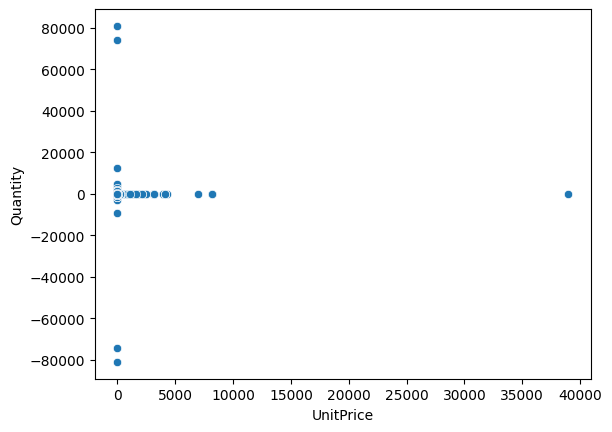

In [26]:
# scatter plot pour voir la relation entre la quantité du produit acheté et son prix unitaire
sns.scatterplot(x="UnitPrice", y="Quantity", data=df)
plt.show()

Observation:
- les outliers ont trop d'impacts sur la visualisation
- enlever les outliers pour y voir plus claire

## Outliers

In [27]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [28]:
df_without_outliers = remove_outliers_df(df, cols=["Quantity", "UnitPrice"], threshold=100)
df_without_outliers.describe()

,Quantity,UnitPrice,CustomerID
count,401356.000000,401356.000000,401356.000000
mean,11.807375,2.991769,15281.448435
std,32.597322,4.596181,1713.901933
min,-960.000000,0.000000,12347.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16788.000000
max,1010.000000,250.000000,18287.000000


In [52]:
df_without_outliers.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


## Feature engineering

In [53]:
# Conversion de la colonne 'date_time' en datetime
df_without_outliers['InvoiceDate'] = pd.to_datetime(df_without_outliers['InvoiceDate'])

In [55]:
# Extraction de l'année, du mois et du jour dans des colonnes séparées
df_without_outliers['YEAR'] = df_without_outliers['InvoiceDate'].dt.year
df_without_outliers['MONTH'] = df_without_outliers['InvoiceDate'].dt.month
df_without_outliers['DAY'] = df_without_outliers['InvoiceDate'].dt.day

## Visualisation (sans outliers)

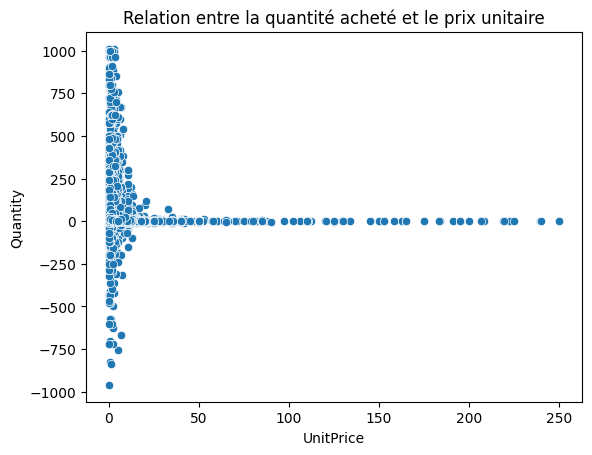

In [29]:
# scatter plot pour voir la relation entre la quantité du produit acheté et son prix unitaire
sns.scatterplot(x="UnitPrice", y="Quantity", data=df_without_outliers)
plt.title('Relation entre la quantité acheté et le prix unitaire')
plt.show()

Observation:
- Pour un produit, plus le prix diminue, plus il aura tendance à être acheté en grande quantité, et inversement (corrélation négative)
- Les quantité négative sont surement du à un remboursement du produit
- Pour une meilleur analyse, séparer les analyse sur les produits achetés et sur les produits remboursés
- barplot en regroupant les quantité par intervalle

In [30]:
# Créer deux df : df_achat et df_rembrousement
df_achat = df_without_outliers.loc[df_without_outliers["Quantity"] > 0]
df_remboursement = df_without_outliers.loc[df_without_outliers["Quantity"] < 0]

In [31]:
# Créer la colonne bins_quantity 
bins = list(range(0, 1100, 100))
bins_neg = list(range(0, -1100, -100))
bins_neg.reverse()
df_achat["bins_quantity"] = pd.cut(df_achat["Quantity"], bins=bins) 
df_remboursement["bins_quantity"] = pd.cut(df_remboursement["Quantity"], bins=bins_neg) 

/tmp/ipykernel_4605/138893504.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_achat["bins_quantity"] = pd.cut(df_achat["Quantity"], bins=bins)
/tmp/ipykernel_4605/138893504.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_remboursement["bins_quantity"] = pd.cut(df_remboursement["Quantity"], bins=bins_neg)


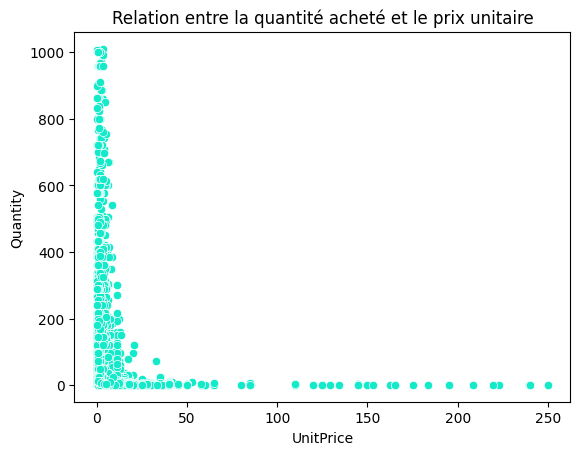

In [32]:
# scatter plot pour voir la relation entre la quantité du produit acheté et son prix unitaire
sns.scatterplot(x="UnitPrice", y="Quantity", color ="#13EAC9", data=df_achat)
plt.title('Relation entre la quantité acheté et le prix unitaire')
plt.show()

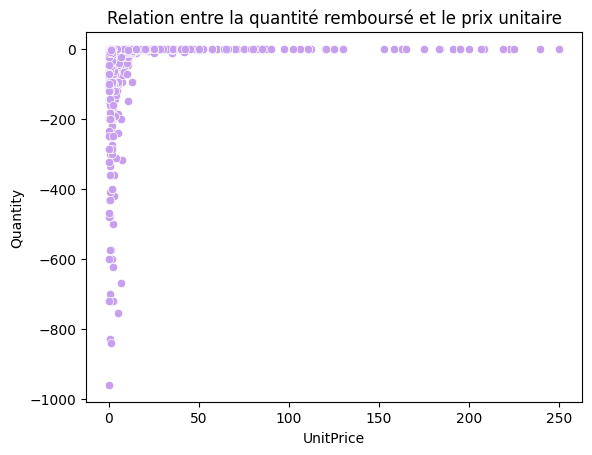

In [33]:
# scatter plot pour voir la relation entre la quantité du produit acheté et son prix unitaire
sns.scatterplot(x="UnitPrice", y="Quantity", color ="#C79FEF", data=df_remboursement)
plt.title('Relation entre la quantité remboursé et le prix unitaire')
plt.show()

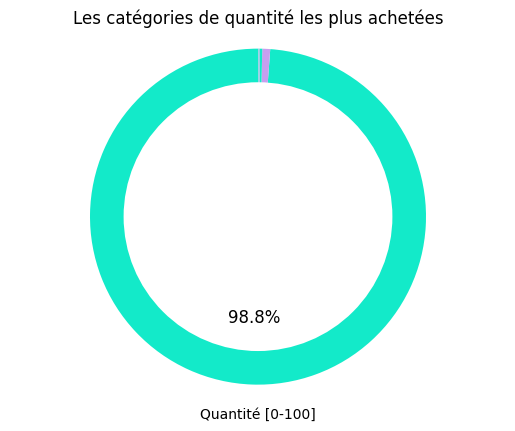

In [57]:
# Compter les occurrences de chaque catégorie dans la colonne "bins_quantity"
quantities_count = df_achat['bins_quantity'].value_counts()
pie_colors = ["#13EAC9", "#C79FEF"]

# Sélectionner les 10 catégories de quantité les plus fréquentes
top_quantities = quantities_count.head(10)

# Fonction pour formater le pourcentage
def format_autopct(pct):
    if pct > 10:
        return f"{pct:.1f}%"
    else:
        return ''
    
fig, ax = plt.subplots()

# Créer le pie chart
ax.pie(top_quantities, labels=['']*len(top_quantities), colors = pie_colors, autopct=format_autopct, startangle=90, textprops={'fontsize': 12})
plt.title("Les catégories de quantité les plus achetées")
plt.axis('equal')  # Assure un aspect circulaire
plt.xlabel("Quantité [0-100]")  # Ajout du ylabel

# Changing the pie chart to dont chart

centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

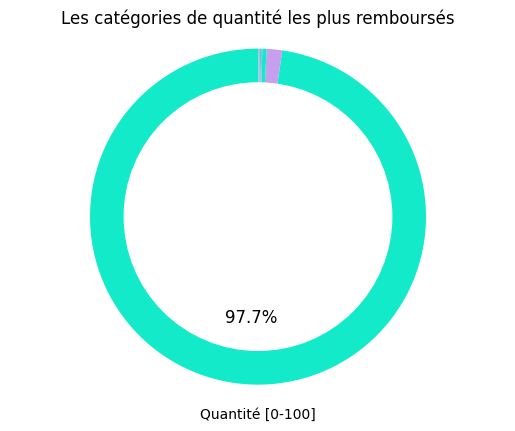

In [58]:
# Compter les occurrences de chaque catégorie dans la colonne "bins_quantity"
quantities_count = df_remboursement['bins_quantity'].value_counts()
pie_colors = ["#13EAC9", "#C79FEF"]

# Sélectionner les 10 catégories de quantité les plus fréquentes
top_quantities = quantities_count.head(10)

# Fonction pour formater le pourcentage
def format_autopct(pct):
    if pct > 10:
        return f"{pct:.1f}%"
    else:
        return ''
    
fig, ax = plt.subplots()

# Créer le pie chart
ax.pie(top_quantities, labels=['']*len(top_quantities), colors = pie_colors, autopct=format_autopct, startangle=90, textprops={'fontsize': 12})
plt.title("Les catégories de quantité les plus remboursés")
plt.axis('equal')  # Assure un aspect circulaire
plt.xlabel("Quantité [0-100]")  # Ajout du ylabel

# Changing the pie chart to dont chart

centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

In [36]:
df_without_outliers.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [37]:
df_without_outliers.describe()

,Quantity,UnitPrice,CustomerID
count,401356.000000,401356.000000,401356.000000
mean,11.807375,2.991769,15281.448435
std,32.597322,4.596181,1713.901933
min,-960.000000,0.000000,12347.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16788.000000
max,1010.000000,250.000000,18287.000000


In [38]:
# Créer la colonne total_price
df_without_outliers["total_price"] = df_without_outliers["Quantity"] * df_without_outliers["UnitPrice"]

In [39]:
# groupby par Country avec Total_price
groupby_country = df_without_outliers.groupby(by="Country")["total_price"].sum()

# transformer en dataframe
df_country = groupby_country.to_frame().reset_index()


# Triez le DataFrame par la colonne "total_price" dans l'ordre croissant
df_sorted_country = df_country.sort_values(by="total_price", ascending=False)
df_sorted_country_top10 = df_sorted_country.head(10)
df_sorted_country_top10

,Country,total_price
35,United Kingdom,6652794.124
23,Netherlands,274738.980
10,EIRE,251327.070
14,Germany,220986.470
13,France,196626.050
0,Australia,136288.900
30,Spain,57597.880
32,Switzerland,55739.400
3,Belgium,40910.960
31,Sweden,36585.410


In [40]:
# groupby par Country avec Total_price
groupby_country_quan = df_without_outliers.groupby(by="Country")["Quantity"].sum()

# transformer en dataframe
df_country_quan = groupby_country_quan.to_frame().reset_index()

# Triez le DataFrame par la colonne "Quantity" dans l'ordre croissant
df_sorted_country_quan = df_country_quan.sort_values(by="Quantity", ascending=False)
df_sorted_country_quan_top10 = df_sorted_country_quan.head(10)
df_sorted_country_quan_top10

,Country,Quantity
35,United Kingdom,3855310
23,Netherlands,191920
10,EIRE,134749
14,Germany,117340
13,France,109806
0,Australia,82491
31,Sweden,35632
32,Switzerland,29778
30,Spain,26819
3,Belgium,23152


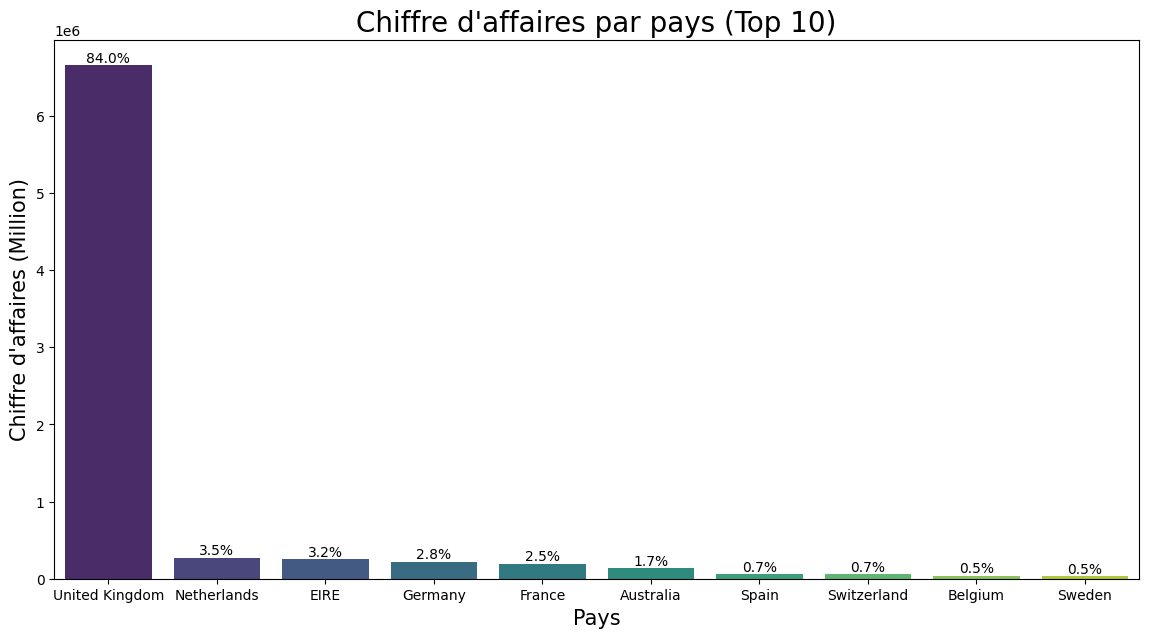

In [75]:
# Bar plot du chiffre d'affaire par pays
fig, ax = plt.subplots(figsize=(14, 7))  # Créer une figure et des axes personnalisables
sns.barplot(x="Country", y="total_price", data=df_sorted_country_top10, ax=ax, palette="viridis")

# Obtenir les hauteurs des barres
bar_heights = [bar.get_height() for bar in plt.gca().patches]

# Calculer les pourcentages
total = sum(bar_heights)
percentages = [(height / total) * 100 for height in bar_heights]

# Ajouter les pourcentages à chaque barre
for bar, percentage in zip(plt.gca().patches, percentages):
    plt.gca().annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black')

# Agrandir le titre, xlabel et ylabel
ax.set_title("Chiffre d'affaires par pays (Top 10)", fontsize=20)
ax.set_xlabel("Pays", fontsize=15)
ax.set_ylabel("Chiffre d'affaires (Million)", fontsize=15)

plt.show()

In [50]:
# Chiffre d'affaire total 
CA = round(df_sorted_country["total_price"].sum() / 1e6, 2)
print(f"Le chiffre d'affaire total est de {CA} Million")

Le chiffre d'affaire total est de 8.17 Million


In [79]:
# chiffre d'affaire par année
groupby_CA_year = df_without_outliers.groupby(by="YEAR")["total_price"].sum()

# transformer en dataframe
df_CA_year = groupby_CA_year.to_frame().reset_index()
df_CA_year

,YEAR,total_price
0,2010,542235.920
1,2011,7625374.044


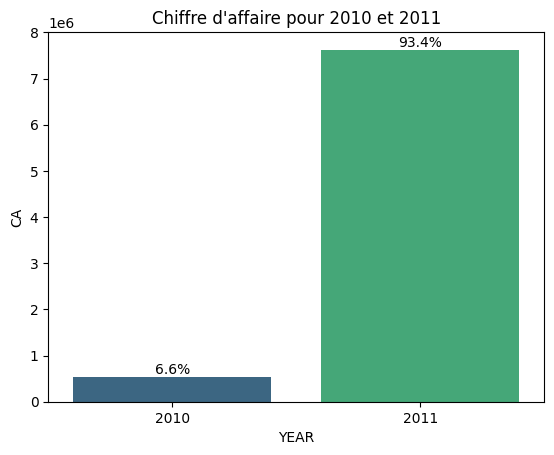

In [97]:
sns.barplot(x='YEAR', y='total_price', data=df_CA_year, palette='viridis')

# Obtenir les hauteurs des barres
bar_heights = [bar.get_height() for bar in plt.gca().patches]

# Calculer les pourcentages
total = sum(bar_heights)
percentages = [(height / total) * 100 for height in bar_heights]

# Ajouter les pourcentages à chaque barre
for bar, percentage in zip(plt.gca().patches, percentages):
    plt.gca().annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black')

plt.title("Chiffre d'affaire pour 2010 et 2011")
plt.ylabel('CA')
plt.show()

In [82]:
# chiffre d'affaire par année
groupby_CA_month = df_without_outliers.groupby(by="MONTH")["total_price"].sum()

# transformer en dataframe
df_CA_month = groupby_CA_month.to_frame().reset_index()
df_CA_month

,MONTH,total_price
0,1,450724.830
1,2,426789.710
2,3,573672.290
3,4,421235.351
4,5,647722.150
5,6,605878.600
6,7,582712.861
7,8,610625.730
8,9,908664.992
9,10,957105.030


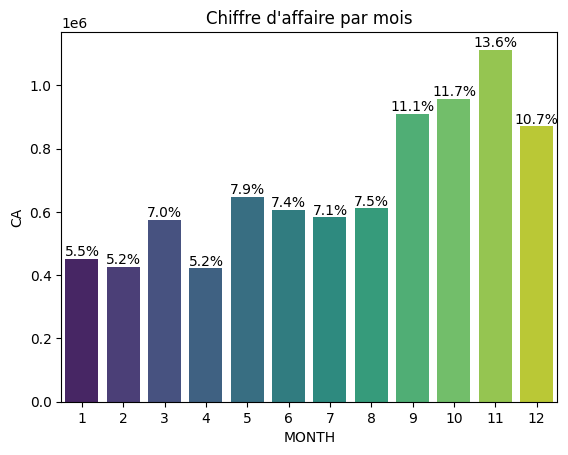

In [83]:
sns.barplot(x='MONTH', y='total_price', data=df_CA_month, palette='viridis')

# Obtenir les hauteurs des barres
bar_heights = [bar.get_height() for bar in plt.gca().patches]

# Calculer les pourcentages
total = sum(bar_heights)
percentages = [(height / total) * 100 for height in bar_heights]

# Ajouter les pourcentages à chaque barre
for bar, percentage in zip(plt.gca().patches, percentages):
    plt.gca().annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black')

plt.title("Chiffre d'affaire par mois")
plt.ylabel('CA')
plt.show()

In [94]:
CA_month_2010 = df_without_outliers.loc[df_without_outliers["YEAR"] == 2010]
CA_month_2011 = df_without_outliers.loc[df_without_outliers["YEAR"] == 2011]

# chiffre d'affaire par année
groupby_CA_month_2010 = CA_month_2010.groupby(by="MONTH")["total_price"].sum()
groupby_CA_month_2011 = CA_month_2011.groupby(by="MONTH")["total_price"].sum()

# transformer en dataframe
df_CA_month_2010 = groupby_CA_month_2010.to_frame().reset_index()
df_CA_month_2011 = groupby_CA_month_2011.to_frame().reset_index()

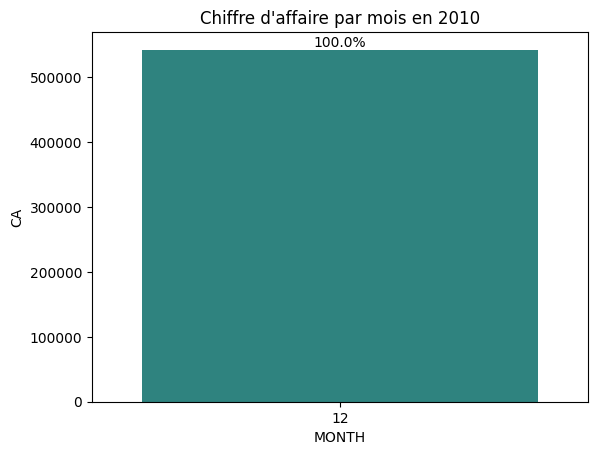

In [95]:
sns.barplot(x='MONTH', y='total_price', data=df_CA_month_2010, palette='viridis')

# Obtenir les hauteurs des barres
bar_heights = [bar.get_height() for bar in plt.gca().patches]

# Calculer les pourcentages
total = sum(bar_heights)
percentages = [(height / total) * 100 for height in bar_heights]

# Ajouter les pourcentages à chaque barre
for bar, percentage in zip(plt.gca().patches, percentages):
    plt.gca().annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black')

plt.title("Chiffre d'affaire par mois en 2010")
plt.ylabel('CA')
plt.show()

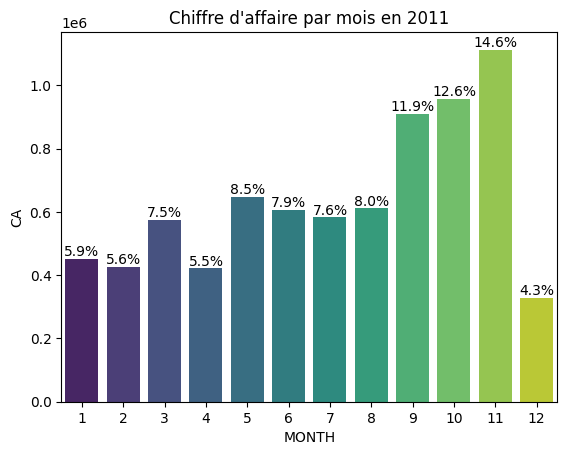

In [96]:
sns.barplot(x='MONTH', y='total_price', data=df_CA_month_2011, palette='viridis')

# Obtenir les hauteurs des barres
bar_heights = [bar.get_height() for bar in plt.gca().patches]

# Calculer les pourcentages
total = sum(bar_heights)
percentages = [(height / total) * 100 for height in bar_heights]

# Ajouter les pourcentages à chaque barre
for bar, percentage in zip(plt.gca().patches, percentages):
    plt.gca().annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black')

plt.title("Chiffre d'affaire par mois en 2011")
plt.ylabel('CA')
plt.show()

In [85]:
# chiffre d'affaire par année
groupby_CA_day = df_without_outliers.groupby(by="DAY")["total_price"].sum()

# transformer en dataframe
df_CA_day = groupby_CA_day.to_frame().reset_index()

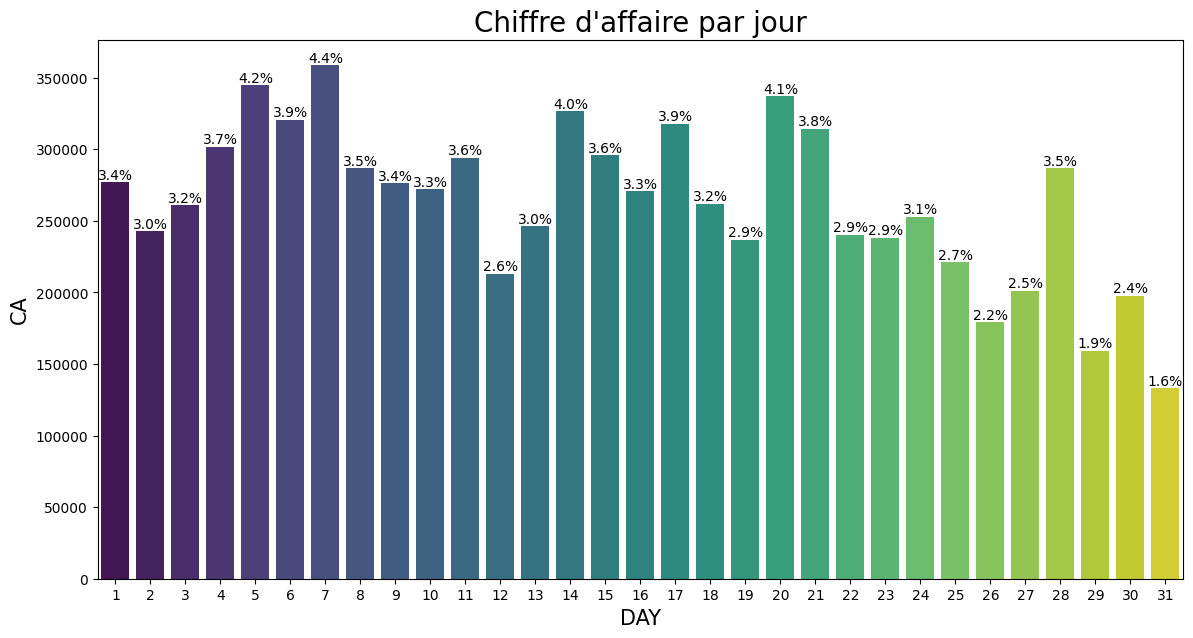

In [88]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.barplot(x='DAY', y='total_price', data=df_CA_day, ax=ax, palette='viridis')

# Obtenir les hauteurs des barres
bar_heights = [bar.get_height() for bar in plt.gca().patches]

# Calculer les pourcentages
total = sum(bar_heights)
percentages = [(height / total) * 100 for height in bar_heights]

# Ajouter les pourcentages à chaque barre
for bar, percentage in zip(plt.gca().patches, percentages):
    plt.gca().annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black')

# Agrandir le titre, xlabel et ylabel
ax.set_title("Chiffre d'affaire par jour", fontsize=20)
ax.set_xlabel("DAY", fontsize=15)
ax.set_ylabel("CA", fontsize=15)
plt.show()

### Calcule du ROI

- ROI sur le chiffre d'affaires = (Chiffre d'affaires - Coûts) / Coûts
- Pour calculer le ROI (Return on Investment) à partir des données disponible, il manque une information clé : les coûts associés à la génération des revenus.
- j'aurai donc besoin de connaître les coûts associés à la production, à la commercialisation, à la distribution, etc.

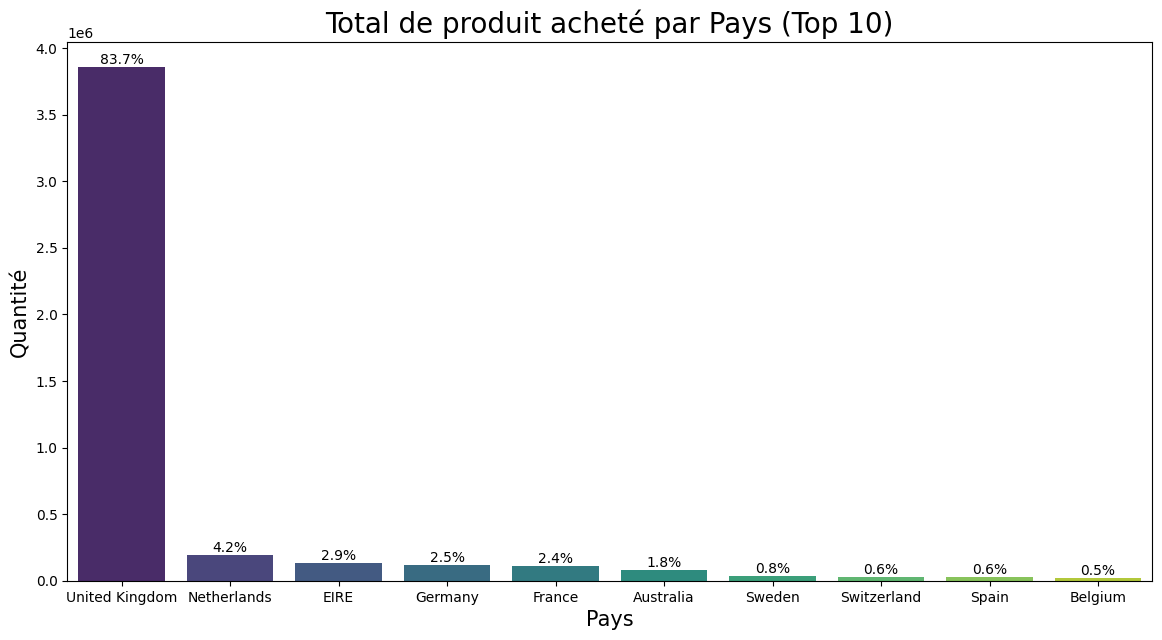

In [76]:
# Barplot total de produit acheté par Pays
fig, ax = plt.subplots(figsize=(14, 7))  # Créer une figure et des axes personnalisables
sns.barplot(x="Country", y="Quantity", data=df_sorted_country_quan_top10, ax=ax, palette="viridis")

# Obtenir les hauteurs des barres
bar_heights = [bar.get_height() for bar in plt.gca().patches]

# Calculer les pourcentages
total = sum(bar_heights)
percentages = [(height / total) * 100 for height in bar_heights]

# Ajouter les pourcentages à chaque barre
for bar, percentage in zip(plt.gca().patches, percentages):
    plt.gca().annotate(f'{percentage:.1f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black')

# Agrandir le titre, xlabel et ylabel
ax.set_title("Total de produit acheté par Pays (Top 10)", fontsize=20)
ax.set_xlabel("Pays", fontsize=15)
ax.set_ylabel("Quantité", fontsize=15)

plt.show()

In [44]:
df_without_outliers.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [45]:
# groupby par Country avec Total_price
groupby_description_quan = df_achat.groupby(by="Description")["Quantity"].sum()

# transformer en dataframe
df_description_quan = groupby_description_quan.to_frame().reset_index()

# Triez le DataFrame par la colonne "Quantity" dans l'ordre décroissant 
df_sorted_description_quan = df_description_quan.sort_values(by="Quantity", ascending=True)
df_sorted_description_quan_last10 = df_sorted_description_quan.head(10)
df_sorted_description_quan_last10

,Description,Quantity
851,CRACKED GLAZE EARRINGS RED,1
872,CROCHET LILAC/RED BEAR KEYRING,1
871,CROCHET DOG KEYRING,1
278,BAROQUE BUTTERFLY EARRINGS CRYSTAL,1
850,CRACKED GLAZE EARRINGS BROWN,1
1628,HEN HOUSE W CHICK IN NEST,1
1354,FUNKY MONKEY MUG,1
3414,TEA TIME BREAKFAST BASKET,1
2443,PINK CRYSTAL GUITAR PHONE CHARM,1
359,BLACK FINE BEAD NECKLACE W TASSEL,1


In [46]:
# Triez le DataFrame par la colonne "Quantity" dans l'ordre croissant
df_sorted_description_quan_top = df_description_quan.sort_values(by="Quantity", ascending=False)
df_sorted_description_quan_top10 = df_sorted_description_quan_top.head(10)
df_sorted_description_quan_top10

,Description,Quantity
1762,JUMBO BAG RED RETROSPOT,44878
3783,WORLD WAR 2 GLIDERS ASSTD DESIGNS,35359
3695,WHITE HANGING HEART T-LIGHT HOLDER,32846
216,ASSORTED COLOUR BIRD ORNAMENT,31183
2269,PACK OF 72 RETROSPOT CAKE CASES,29830
2598,POPCORN HOLDER,24327
2047,MINI PAINT SET VINTAGE,23530
540,BROCADE RING PURSE,22927
2235,PACK OF 12 LONDON TISSUES,22737
3531,VICTORIAN GLASS HANGING T-LIGHT,22404


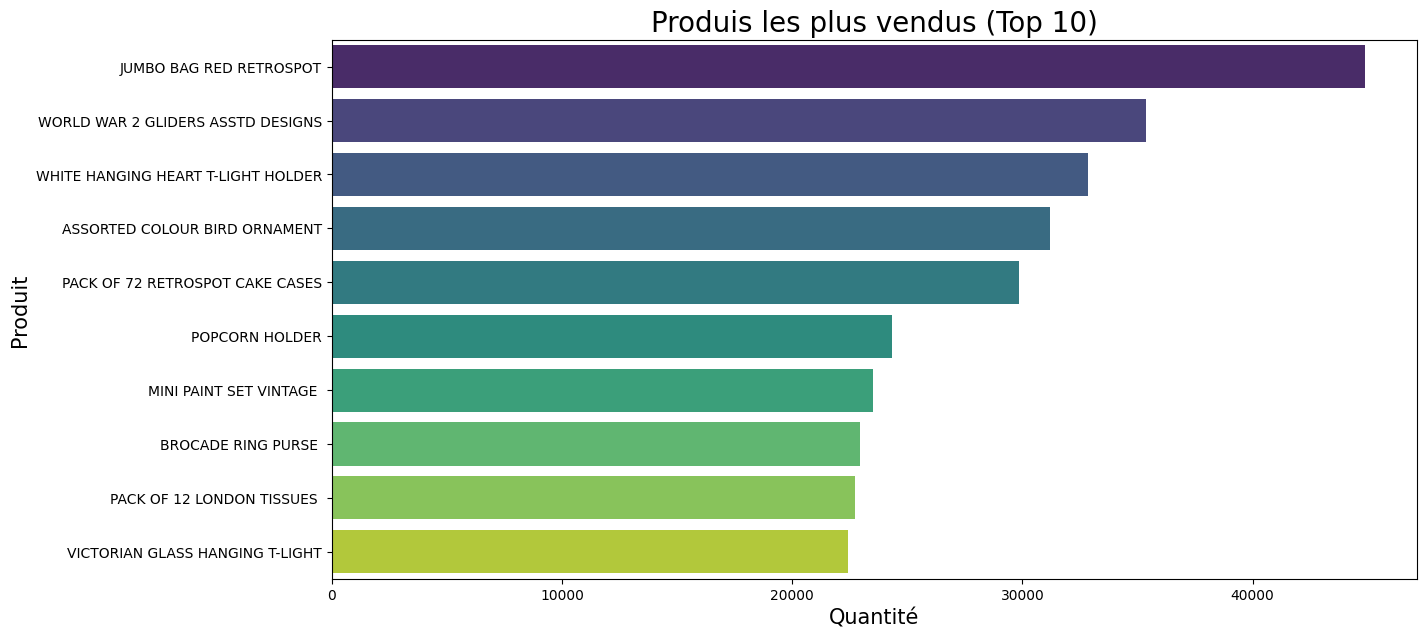

In [78]:
# Barplot sur les produis les plus vendus 
fig, ax = plt.subplots(figsize=(14, 7))  # Créer une figure et des axes personnalisables
sns.barplot(x="Quantity", y="Description", data=df_sorted_description_quan_top10, ax=ax, palette="viridis")

# Agrandir le titre, xlabel et ylabel
ax.set_title("Produis les plus vendus (Top 10)", fontsize=20)
ax.set_xlabel("Quantité", fontsize=15)
ax.set_ylabel("Produit", fontsize=15)

plt.show()

## Model

### Apriori

In [46]:
# Supprimer les colonnes inutiles pour l'analyse Apriori
df_apriori = df_without_outliers[['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice']]

# Convertir la colonne 'InvoiceNo' et 'StockCode' en format de chaîne de caractères
df_apriori['InvoiceNo'] = transform_str_to_int(df_apriori['InvoiceNo'])
df_apriori['StockCode'] = transform_str_to_int(df_apriori['StockCode'])

/tmp/ipykernel_4409/1919493866.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apriori['InvoiceNo'] = transform_str_to_int(df_apriori['InvoiceNo'])
/tmp/ipykernel_4409/1919493866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_apriori['StockCode'] = transform_str_to_int(df_apriori['StockCode'])


In [47]:
df_apriori.head()

,InvoiceNo,StockCode,Quantity,UnitPrice
0,7873,3152,6,2.55
1,7873,2339,6,3.39
2,7873,3037,8,2.75
3,7873,2523,6,3.39
4,7873,1115,6,3.39


In [48]:
df_apriori.shape

(401356, 4)

In [49]:
df_apriori.dtypes

InvoiceNo      int64
StockCode      int64
Quantity       int64
UnitPrice    float64
dtype: object

In [50]:
# # Utiliser la fonction apriori pour extraire les itemsets fréquents
# frequent_itemsets = apriori(df_apriori, min_support=0.05, use_colnames=True)

# # Générer les règles d'association à partir des itemsets fréquents
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Afficher les règles d'association
# print(rules)

### FP-Growth

In [51]:
# Convert the dataset into the required format
transactions = []
for i in range(len(df_without_outliers)):
    transaction = []
    try:
        transaction.append(str(df_without_outliers['InvoiceNo'][i]))
        transaction.append(str(df_without_outliers['StockCode'][i]))
        transaction.append(str(df_without_outliers['Quantity'][i]))
        transaction.append(str(df_without_outliers['UnitPrice'][i]))
        transaction.append(str(df_without_outliers['Description'][i]))
        transaction.append(str(df_without_outliers['CustomerID'][i]))
        transaction.append(str(df_without_outliers['InvoiceDate'][i]))
        transactions.append(transaction)
    except:
        continue

In [163]:
# Convert the dataset into the required format
transactions_2 = []
for i in range(len(df_without_outliers)):
    transaction = []
    try:
        transaction.append(str(df_without_outliers['InvoiceNo'][i]))
        transaction.append(str(df_without_outliers['Quantity'][i]))
        transaction.append(str(df_without_outliers['UnitPrice'][i]))
        transaction.append(str(df_without_outliers['Description'][i]))
        transaction.append(str(df_without_outliers['CustomerID'][i]))
        transaction.append(str(df_without_outliers['InvoiceDate'][i]))
        transactions_2.append(transaction)
    except:
        continue

In [164]:
# Print the converted dataset
len(transactions)

295200

In [165]:
transactions[:1]

[['536365',
  '85123A',
  '6',
  '2.55',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  '17850.0',
  '12/1/2010 8:26']]

In [166]:
len(transactions_2)

295200

In [167]:
transactions_2[:1]

[['536365',
  '6',
  '2.55',
  'WHITE HANGING HEART T-LIGHT HOLDER',
  '17850.0',
  '12/1/2010 8:26']]

In [168]:
# Perform frequent itemset mining using FPGrowth
patterns = pyfpgrowth.find_frequent_patterns(transactions_2, 30)  # Adjust the support threshold as needed

# Generate association rules from the frequent itemsets
rules = pyfpgrowth.generate_association_rules(patterns, 0.7)  # Adjust the confidence threshold as needed

- support threshold = 20 : This means that an itemset must appear in at least 20 transactions to be considered frequent.
- The confidence threshold is a parameter that determines the minimum confidence level required for an association rule to be considered significant. Confidence measures the strength of the relationship between the antecedent and consequent of an association rule.

In [169]:
# Create a DataFrame for frequent itemsets
frequent_itemsets_df = pd.DataFrame.from_records(list(patterns.items()), columns=['Itemset', 'Support'])
frequent_itemsets_df_sorted = frequent_itemsets_df.sort_values(by ='Support', ascending=False)

# Create a DataFrame for association rules
association_rules_df = pd.DataFrame.from_records(list(rules.items()), columns=['Rule', 'Confidence'])

# Combine the frequent itemsets and association rules into a single DataFrame
result_df = pd.concat([frequent_itemsets_df, association_rules_df], axis=1)
result_df_sorted = result_df.sort_values(by ='Support', ascending=False)

In [170]:
frequent_itemsets_df.head()

,Itemset,Support
0,"(TOMATO CHARLIE+LOLA COASTER SET,)",30
1,"(5 HOOK HANGER MAGIC TOADSTOOL,)",30
2,"(PINK NEW BAROQUECANDLESTICK CANDLE,)",30
3,"(BOOM BOX SPEAKER GIRLS,)",30
4,"(GARDEN PATH JOURNAL,)",30


In [171]:
frequent_itemsets_df.shape

(34769, 2)

- Itemset: This column represents the frequent itemsets discovered by the FP-Growth algorithm. An itemset is a set of items that frequently co-occur together in the dataset. It can consist of one or more items. Each row in the column represents a specific itemset found in the dataset.
- Support: This column indicates the support value for each itemset. Support is a measure of how frequently an itemset occurs in the dataset. It represents the proportion or percentage of transactions in the dataset that contain the corresponding itemset. The support value is calculated by dividing the number of transactions containing the itemset by the total number of transactions in the dataset. It can range from 0 to 1, or it can be expressed as a percentage.

In [172]:
association_rules_df.head()

,Rule,Confidence
0,"(GARDEN PATH JOURNAL,)","((2.55,), 1.0)"
1,"(ANTIQUE GLASS HEART DECORATION ,)","((1.95,), 1.0)"
2,"(GREEN JUICY FRUIT PHOTO FRAME,)","((2.55,), 1.0)"
3,"(MULTI HEARTS STICKERS,)","((0.85,), 1.0)"
4,"(PACK 6 HEART/ICE-CREAM PATCHES,)","((1.25,), 1.0)"


In [173]:
association_rules_df.shape

(21762, 2)

In [174]:
frequent_itemsets_df["Support_ratio"] = frequent_itemsets_df["Support"] / len(transactions)

In [175]:
frequent_itemsets_df_sorted["Support_ratio"] = frequent_itemsets_df_sorted["Support"] / len(transactions)

In [176]:
frequent_itemsets_df.head()

,Itemset,Support,Support_ratio
0,"(TOMATO CHARLIE+LOLA COASTER SET,)",30,0.000102
1,"(5 HOOK HANGER MAGIC TOADSTOOL,)",30,0.000102
2,"(PINK NEW BAROQUECANDLESTICK CANDLE,)",30,0.000102
3,"(BOOM BOX SPEAKER GIRLS,)",30,0.000102
4,"(GARDEN PATH JOURNAL,)",30,0.000102


In [195]:
frequent_itemsets_df_sorted.iloc[1000:1100]

,Itemset,Support,Support_ratio
28242,"(9.95, PHOTO FRAME 3 CLASSIC HANGING)",191,0.000647
28968,"(2.55, LONDON BUS COFFEE MUG)",191,0.000647
34654,"(6, 7.95)",191,0.000647
28025,"(15756.0,)",191,0.000647
28021,"(12753.0,)",191,0.000647
...,...,...,...
27927,"(1.25, HEART IVORY TRELLIS SMALL)",183,0.000620
33761,"(1, 15005.0)",183,0.000620
31767,"(2, 7.95, DOORMAT HEARTS)",183,0.000620
27830,"(-24,)",183,0.000620


In [178]:
association_rules_df[['Confidence', 'Confidence_score']] = association_rules_df['Confidence'].apply(pd.Series)

In [179]:
association_rules_df = association_rules_df.rename(columns={'Rule': 'Antecedent', 'Confidence': 'Consequent'})

In [180]:
association_rules_df_sorted = association_rules_df.sort_values(by ='Confidence_score', ascending=True)

In [181]:
association_rules_df.head(5)

,Antecedent,Consequent,Confidence_score
0,"(GARDEN PATH JOURNAL,)","(2.55,)",1.0
1,"(ANTIQUE GLASS HEART DECORATION ,)","(1.95,)",1.0
2,"(GREEN JUICY FRUIT PHOTO FRAME,)","(2.55,)",1.0
3,"(MULTI HEARTS STICKERS,)","(0.85,)",1.0
4,"(PACK 6 HEART/ICE-CREAM PATCHES,)","(1.25,)",1.0


In [182]:
association_rules_df_sorted.head()

,Antecedent,Consequent,Confidence_score
4112,"(17552.0,)","(569007, 9/29/2011 18:51)",0.700000
16208,"(14656.0,)","(1,)",0.700000
4026,"(8/11/2011 15:25,)","(13588.0,)",0.700000
19182,"(17341.0,)","(1,)",0.700637
17459,"(16303.0,)","(563404, 8/16/2011 11:04)",0.701493


In [184]:
association_rules_df_sorted.shape

(21762, 3)

- Antecedent: This column represents the antecedent of an association rule. The antecedent is the set of items that are found in the transactions or dataset and act as the condition or premise of the rule. It specifies the items that must be present for the consequent to occur.
- Consequent: This column represents the consequent of an association rule. The consequent is the item or set of items that are predicted or implied to occur in a transaction given the presence of the antecedent. It represents the item(s) that are expected to be found in the transaction based on the association rule.
- Confidence_score: This column represents the confidence score associated with the association rule. Confidence is a measure of the conditional probability of the consequent occurring given the antecedent. It indicates the strength of the rule or the likelihood of the consequent appearing in a transaction when the antecedent is present.

### Export des données

In [185]:
association_rules_df.to_csv("data/association_rules_df_2.csv", index=True)

### Ré-import des données 

In [186]:
df_réimport = pd.read_csv("data/association_rules_df.csv")
df_réimport.head()

,Unnamed: 0,Antecedent,Consequent,Confidence_score
0,0,"('536370',)","('12/1/2010 8:45', '12583.0')",1.0
1,1,"('12/1/2010 8:45',)","('12583.0', '536370')",1.0
2,2,"('12/1/2010 8:45', '12583.0')","('536370',)",1.0
3,3,"('12/1/2010 8:45', '536370')","('12583.0',)",1.0
4,4,"('12583.0', '536370')","('12/1/2010 8:45',)",1.0


In [194]:
df_réimport_2 = pd.read_csv("data/association_rules_df_2.csv")
df_réimport_2.head()

,Unnamed: 0,Antecedent,Consequent,Confidence_score
0,0,"('GARDEN PATH JOURNAL',)","('2.55',)",1.0
1,1,"('ANTIQUE GLASS HEART DECORATION ',)","('1.95',)",1.0
2,2,"('GREEN JUICY FRUIT PHOTO FRAME',)","('2.55',)",1.0
3,3,"('MULTI HEARTS STICKERS',)","('0.85',)",1.0
4,4,"('PACK 6 HEART/ICE-CREAM PATCHES',)","('1.25',)",1.0


In [199]:
# Définir la valeur spécifique recherchée
valeur_recherchee = 'POPART WOODEN PENCILS ASST'

# Utiliser la méthode apply() avec une fonction lambda pour rechercher la valeur
resultats = df_réimport_2[df_réimport_2['Consequent'].apply(lambda x: valeur_recherchee in x)]

# Afficher les résultats
resultats

,Unnamed: 0,Antecedent,Consequent,Confidence_score
9657,9657,"('0.04',)","('100', 'POPART WOODEN PENCILS ASST')",0.875
9659,9659,"('0.04', '100')","('POPART WOODEN PENCILS ASST',)",1.000
